# 🧠 [Part V] Explainability with Input Perturbation Attribution (IPA)
In this section, we explore the interpretability of our Variational Quantum Classifier (VQC) by analyzing which input features most influence its predictions. While classical machine learning has mature tools for explainability, such as SHAP or feature importance in decision trees, quantum models remain largely black boxes. To address this, we implement Input Perturbation Attribution (IPA) - a simple but effective technique adapted for hybrid quantum-classical models.

### 🧪 What is IPA?
IPA works by systematically perturbing each input feature (in our case, PCA components) and observing how the model’s output probabilities change. The larger the shift in predicted output, the more important that feature is assumed to be. This gives us a proxy for feature relevance, without requiring gradients or internal access to the quantum circuit.

### ⚙️ How We Apply It
We perturb each PCA input component by a small angle (π/8).

We run inference on both the original and perturbed inputs using the trained VQC model.

We compute the average change in predicted class probabilities to quantify sensitivity.

### 🔄 Mapping PCA Back to Original Features
Since our input to the quantum model was reduced to 2 dimensions using PCA, we project the attribution scores back to the original feature space. This allows us to identify which RDKit chemical descriptors contributed most to the PCA components that influenced the VQC’s decision-making.

### 🎯 Why This Matters
Interpretability is critical in scientific applications like drug safety classification. By identifying high-impact features, we can:
- Gain insight into which chemical properties are most predictive of autoimmunity risk.
- Justify model decisions to domain experts.
- Highlight directions for further feature engineering or refinement.

In [ ]:
# install libraries if haven't
!pip install qiskit==1.4.2 torch qiskit-machine-learning pylatexenc

In [3]:
# import libraries
import torch
import torch.nn as nn
from torch.autograd import Function
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.circuit.library import EfficientSU2
from qiskit_machine_learning.utils import algorithm_globals

from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# show all columns
pd.set_option('display.max_columns', None)

In [4]:
# load training data
df_train = pd.read_csv("DIA_trainingset_RDKit_descriptors.csv")
df_train.head()

,Label,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,COC(=O)N(C)c1c(N)nc(nc1N)c2nn(Cc3ccccc3F)c4ncc...,1.821,1266.407,22.121,16.781,16.781,14.901,9.203,9.203,6.668,6.668,4.719,4.719,3.241,3.241,6.093,9.185,0.0,35.509,22.291,4.900,20.224,41.210,0.000,24.787,11.467,422.162,0.150,-4.28,31,403.272,1.218475e+07,20.012,7.859,3.564,175.833,14.164,0.452,14.164,0.413,0.018,0.413,-0.668,-0.452,2.443,113.689,422.424,4,10,0,0,0,1,3,4,9,2,11,0,6,0,0,0,158,16.204,17.199,23.107,0.0,0.000,6.093,4.900,28.819,5.099,0.000,18.199,18.199,18.808,19.041,4,13.922,34.450,0.000,24.732,0.000,6.545,30.525,53.976,0,11.518,16.367,26.508,0.0,0.000,44.983,11.282,5.817,5.563,42.595,0.0,22.552,0,138.07,0,0.000,0,0,0,0,0,0,15.727,62.940,0,0,0,2,0,5,0,0,0,0,1,1,0,0,0,6,0,2,0,0,0,0,0,0,0,0,0,1,0,3,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,C[C@H](N(O)C(=O)N)c1cc2ccccc2s1,2.363,490.434,11.707,8.752,9.569,7.592,4.854,5.670,3.545,4.661,2.449,3.735,1.520,2.621,12.073,10.002,0.0,0.000,5.063,14.963,0.000,18.261,30.332,0.000,5.734,236.062,0.182,-1.59,16,224.200,5.774616e+03,10.912,4.112,1.868,96.858,10.832,0.350,10.832,0.339,0.421,0.339,-0.843,-0.350,2.732,63.449,236.296,3,4,0,0,0,1,1,2,3,2,5,0,3,0,0,0,84,5.734,0.000,0.000,0.0,0.000,6.031,5.207,4.795,5.063,11.337,18.199,24.443,9.577,6.042,2,10.002,27.454,0.000,5.063,5.734,12.966,0.000,35.209,0,0.000,5.734,4.795,0.0,11.337,16.302,0.000,0.000,17.843,30.332,0.0,10.086,0,66.56,0,1.542,0,0,0,0,0,0,0.000,39.292,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
2,0,C[N+](C)(C)CC(=O)[O-],3.551,93.092,6.784,5.47

In [5]:
# load the rest
df_test = pd.read_csv("DIA_testset_RDKit_descriptors.csv")
df_scaled_train = pd.read_csv("DIA_trainingset_scaled.csv")
df_scaled_test = pd.read_csv("DIA_testset_scaled.csv")

In [6]:
# prepare the data as numpy
X_train = df_train.iloc[:, 2:].values.astype(np.float32)
X_train

array([[1.821000e+00, 1.266407e+03, 2.212100e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.363000e+00, 4.904340e+02, 1.170700e+01, ..., 1.000000e+00,
        0.000000e+00, 1.000000e+00],
       [3.551000e+00, 9.309200e+01, 6.784000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.766000e+00, 9.100310e+02, 2.112900e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.831000e+00, 9.261910e+02, 1.851800e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.617000e+00, 1.565385e+03, 3.054500e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)

In [13]:
# prepare train data
y_train = df_train.iloc[:, 0].values.astype(np.float32).reshape(-1, 1)

In [8]:
# prepare X test data
X_test = df_test.iloc[:, 2:].values.astype(np.float32)
X_test

array([[1.484000e+00, 7.432070e+02, 2.146600e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.472000e+00, 8.689470e+02, 2.114000e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [8.370000e-01, 1.409004e+03, 3.918900e+01, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [1.670000e+00, 5.934880e+02, 1.536400e+01, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.603000e+00, 9.023710e+02, 2.242200e+01, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [2.814000e+00, 1.098030e+02, 1.048500e+01, ..., 0.000000e+00,
        9.000000e+00, 0.000000e+00]], dtype=float32)

In [9]:
y_test = df_test.iloc[:, 0].values.astype(np.float32).reshape(-1, 1)
y_test

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],

In [10]:
# prepare the scaled values
X_train_scaled = df_scaled_train.values.astype(np.float32)
X_train_scaled

array([[-0.45287475,  1.3444654 ,  0.551264  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3103219 , -0.63225657, -0.8871936 , ...,  0.5       ,
         0.        ,  1.        ],
       [ 1.9831588 , -1.6444498 , -1.5671943 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.53032094,  0.43662933,  0.41424173, ...,  0.        ,
         0.        ,  0.        ],
       [-0.43879366,  0.47779548,  0.05359136, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7401296 ,  2.106085  ,  1.7148483 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [11]:
X_test_scaled = df_scaled_test.values.astype(np.float32)
X_test_scaled

array([[-0.92740846,  0.01166007,  0.46079063, ...,  0.        ,
         0.        ,  0.        ],
       [-0.94430584,  0.3319715 ,  0.4157611 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.8384569 ,  1.7077185 ,  2.9088206 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.6654997 , -0.36973572, -0.3820621 , ...,  0.5       ,
         0.        ,  0.        ],
       [ 0.64826876,  0.41711617,  0.5928403 , ...,  0.        ,
         0.05555556,  0.        ],
       [ 0.94538033, -1.6018801 , -1.0559852 , ...,  0.        ,
         0.5       ,  0.        ]], dtype=float32)

In [14]:
# doublecheck
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(477, 196)
(120, 196)
(477, 1)
(120, 1)
(477, 196)
(120, 196)


## Model Training
We'll once again train the model, and then from the model we'll get a bunch of its feature importances.

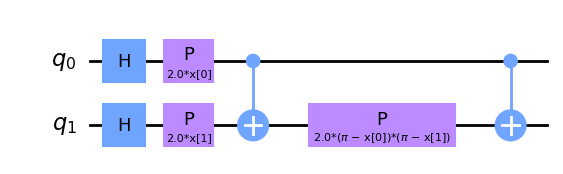

In [15]:
# we encode the 2D PCA features into quantum states using ZZ interaction
num_features = 2

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

In [16]:
# define callback graph
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

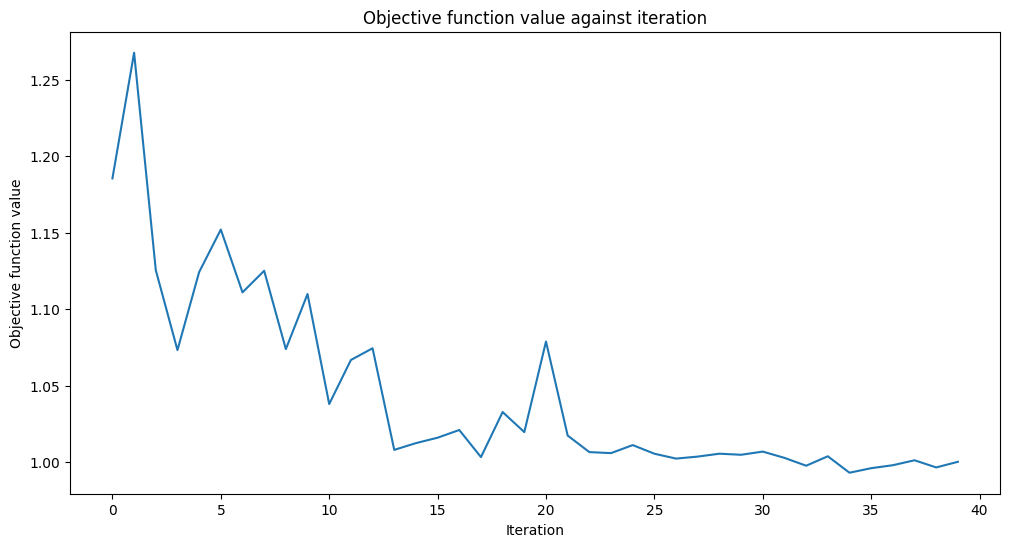

Training time: 180 seconds
Quantum VQC at N=2 on the training dataset: 0.57
Quantum VQC at N=2 on the test dataset:     0.57
N=2
              precision    recall  f1-score   support

         0.0       0.60      0.79      0.68        68
         1.0       0.53      0.31      0.39        52

    accuracy                           0.58       120
   macro avg       0.57      0.55      0.54       120
weighted avg       0.57      0.58      0.56       120




In [17]:
# train a model where there are 2 qubits
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

pca = PCA(n_components=2)
temp_X_train_scaled_pca = pca.fit_transform(X_train_scaled)
temp_X_test_scaled_pca = pca.transform(X_test_scaled)

ansatz = RealAmplitudes(num_qubits=2, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

optimizer = COBYLA(maxiter=40)

sampler = Sampler()

vqc = VQC(
  sampler=sampler,
  feature_map=feature_map,
  ansatz=ansatz,
  optimizer=optimizer,
  callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(temp_X_train_scaled_pca, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

temp_train_score = vqc.score(temp_X_train_scaled_pca, y_train)
temp_test_score = vqc.score(temp_X_test_scaled_pca, y_test)

print(f"Quantum VQC at N=2 on the training dataset: {temp_train_score:.2f}")
print(f"Quantum VQC at N=2 on the test dataset:     {temp_test_score:.2f}")

print("N=2")
print(classification_report(vqc.predict(temp_X_test_scaled_pca), y_test))
print("")

## Model perturbation
In this unique approach, we use Input Perturbation Attribution (IPA) and Principal Component Analysis (PCA) to extract interpretable insights from quantum models. By training a VQC on PCA-reduced features derived from high-dimensional RDKit molecular descriptors, we make quantum modeling feasible under current qubit limitations.

It is a simple and elegant way to retrieve the features that we need.

In [25]:
def ipa_qiskit_vqc(model, X, epsilon=np.pi/8):
    """
    Input Perturbation Attribution for Qiskit VQC using predict_proba output.
    """
    base_probs = model.predict_proba(X)
    importances = []

    for i in range(X.shape[1]):
        X_perturbed = X.copy()
        X_perturbed[:, i] += epsilon

        perturbed_probs = model.predict_proba(X_perturbed)

        # Absolute change in predicted probabilities
        diff = np.abs(perturbed_probs - base_probs)
        avg_shift = np.mean(diff)
        importances.append(avg_shift)

    return importances


In [26]:
attributions = ipa_qiskit_vqc(vqc, temp_X_test_scaled_pca)
print("IPA scores (PCA components):", attributions)

IPA scores (PCA components): [np.float64(0.08427734375), np.float64(0.0799560546875)]


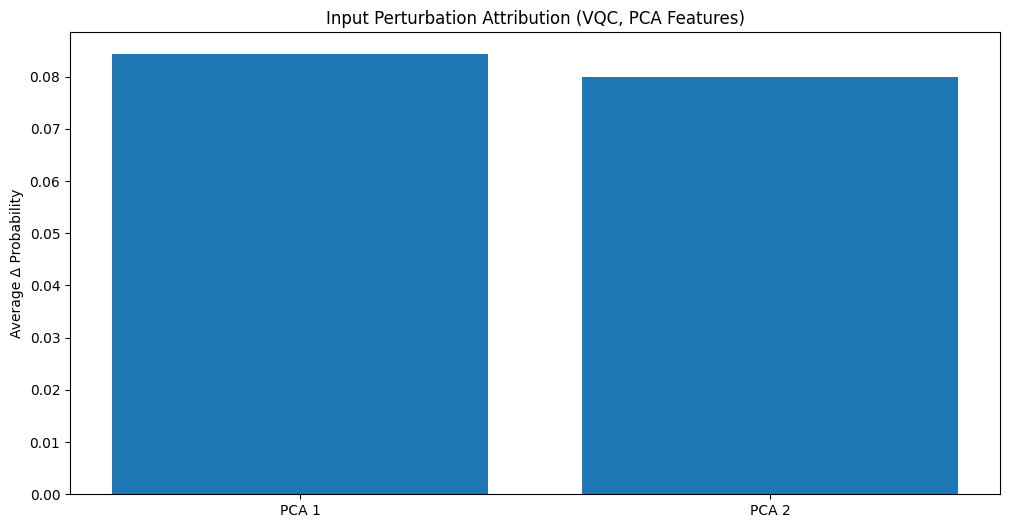

In [27]:
plt.bar(["PCA 1", "PCA 2"], attributions)
plt.title("Input Perturbation Attribution (VQC, PCA Features)")
plt.ylabel("Average Δ Probability")
plt.show()

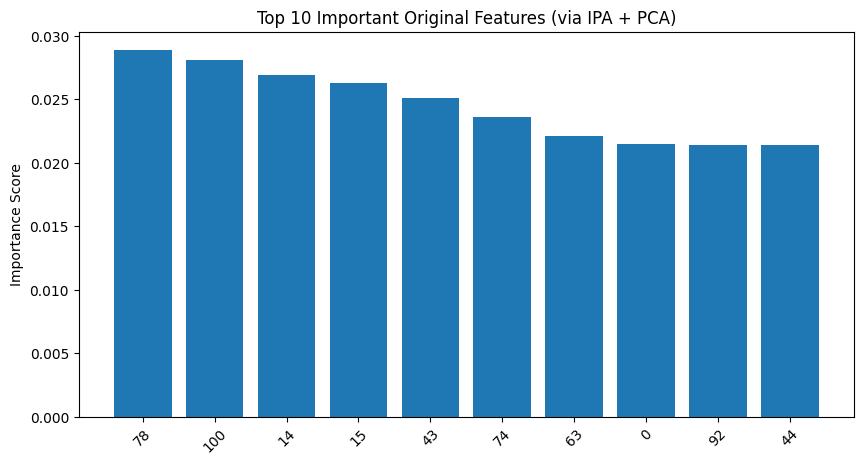

In [28]:
# Absolute contribution of each original feature to each PCA component
abs_pca_weights = np.abs(pca.components_.T)  # shape: (num_original_features, 2)

# Weighted sum of PCA attributions
original_feature_importance = abs_pca_weights @ attributions

# Top 10 contributing original features
top_idx = np.argsort(original_feature_importance)[-10:][::-1]
plt.figure(figsize=(10, 5))
plt.bar(range(10), original_feature_importance[top_idx])
plt.xticks(range(10), top_idx, rotation=45)
plt.title("Top 10 Important Original Features (via IPA + PCA)")
plt.ylabel("Importance Score")
plt.show()

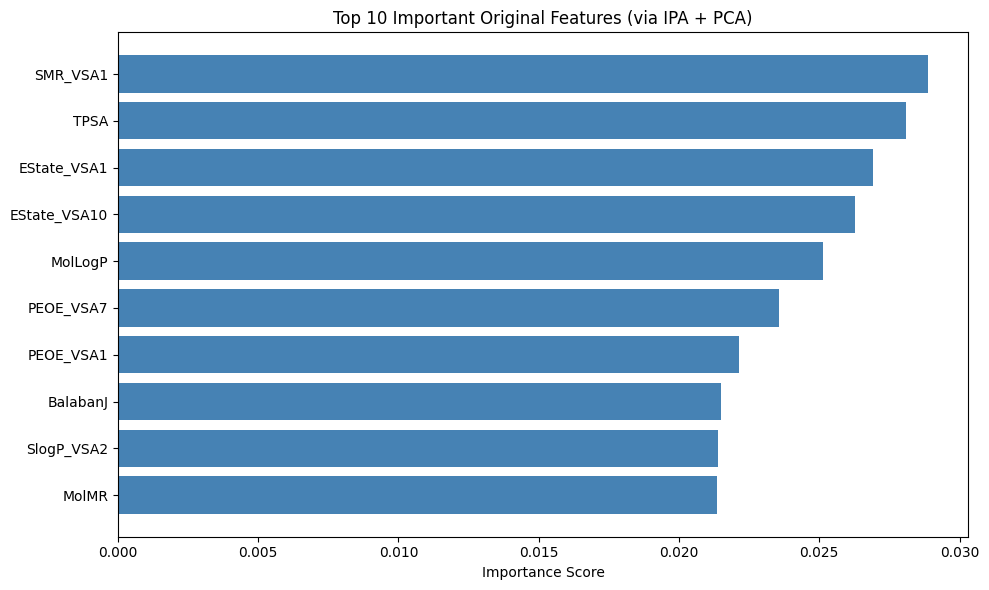

In [37]:
# Map the features back to their names
feature_names = df_scaled_train.columns
top_feature_names = feature_names[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(10), original_feature_importance[top_idx], color='steelblue')
plt.yticks(range(10), top_feature_names)
plt.xlabel("Importance Score")
plt.title("Top 10 Important Original Features (via IPA + PCA)")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


# 🎯 Conclusion
Using Input Perturbation Attribution (IPA) and PCA back-projection, we identified which original RDKit chemical descriptors contributed most to the VQC's decision-making.

These descriptors may represent key structural or physicochemical properties related to drug-induced autoimmunity (DIA). This quantum-enhanced interpretation could guide future mechanistic studies, descriptor engineering, or screening filters.

- ✅ This method is model-agnostic and respects quantum-classical hybrid architecture.
- ✅ It offers a plausible bridge between quantum model behavior and real-world chemistry.
